## Import Statements

In [1]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

## Setup Global Parameters

In [2]:
###----------------
### Some parameters
###----------------

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 10000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Generate Data Set
<div style="font-family: Arial; font-size:1.2em;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [3]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0], dtype=int64))

## Visualization
<p style="font-family: Arial; font-size:1.2em">
DataFrames are easier to visualize
</p>

In [4]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])

data_df['target'] = y

data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [6]:
data_df.describe() # Generate descriptive statistic

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


In [7]:
# what labels are present?
data_df.target.unique()

array([0, 1], dtype=int64)

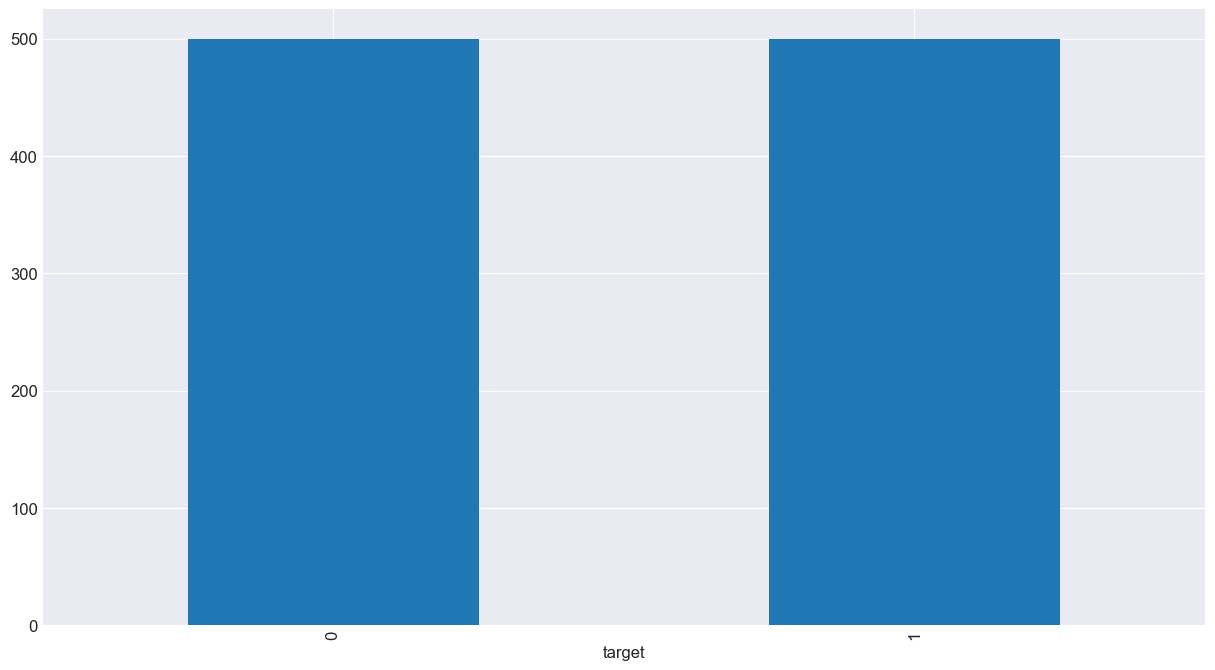

In [8]:
fig, ax = plt.subplots() # Instantiate
    
data_df['target'].value_counts().plot(ax=ax, kind='bar');

### Different ways of plotting data

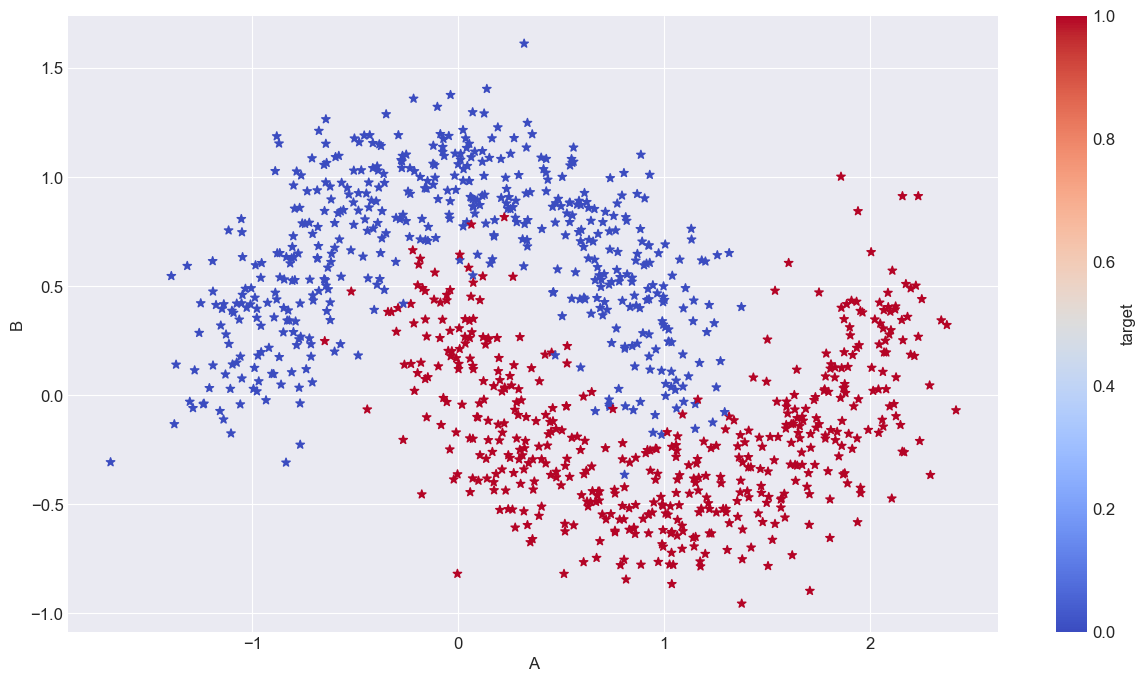

In [9]:
# Plot the data
data_df.plot.scatter('A', 'B',      # columns to plot
                     s = 40,        # size of the marker
                     marker = '*',  # type of marker
                     c = 'target',  # color as per target column
                     cmap=CMAP);    # using colormap

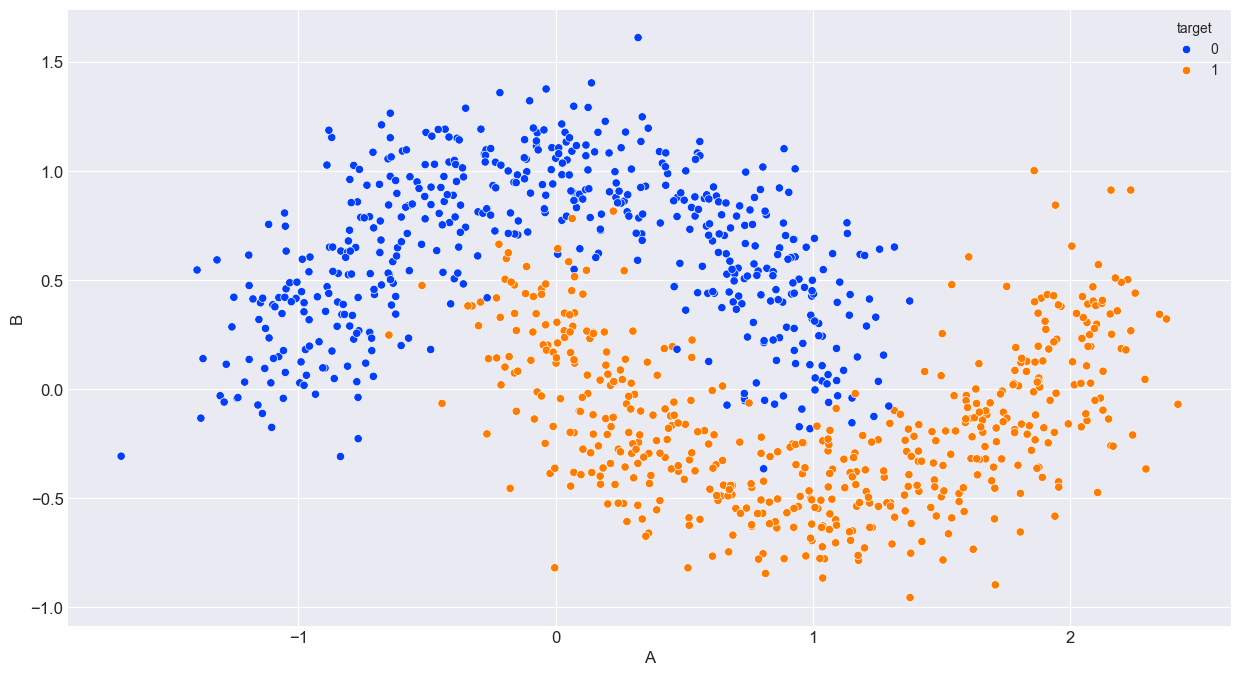

In [10]:
# Using Seaborn
ax = sns.scatterplot(data=data_df, # data from dataframe
                     x='A', y='B',  # X axis and y axis columns
                     palette=sns.color_palette("bright", 2), # color map
                     hue='target'); # Color as per target column

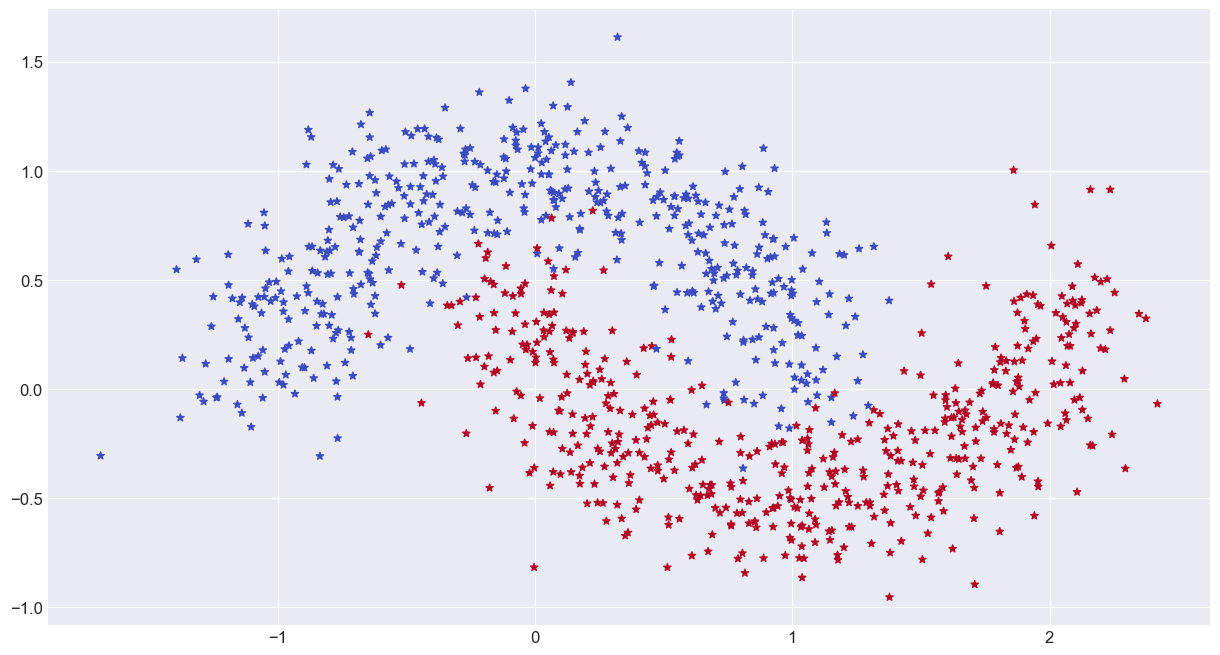

In [11]:
#### In case you want to plot X Array directly
plt.scatter(X[:,0], X[:,1], s=30, c=y, marker = '*', cmap=CMAP);

In [12]:
X_train,X_test, y_train,y_test =train_test_split(X,y,test_size=TEST_SIZE,stratify=y,random_state = RANDOM_STATE)

In [13]:
X_train.shape,X_test.shape, y_train.shape,y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [14]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [15]:
###### without using activation function

In [16]:
def fn_sigmoid(z):
    return 1/(1+np.exp(-z))

def fn_activ(z):
    return np.tanh(z)

def fn_active_prime(z):
    return 1.-np.tanh(z)**2

In [17]:
def predict(model, X_p):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    #### forward propagation

    ## layer 1
    Z1 = X_p.dot(W1)+b1
    a1 = fn_activ(Z1)

    ### Layer 2
    Z2 = a1.dot(W2)+b2
    a2 = fn_sigmoid(Z2)
    
    return a2>=0.5

In [18]:
def Cal_loss(model, X_l,y_l):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    m= X_l.shape[0]
    
    #### forward propagation

    ## layer 1
    Z1 = X_l.dot(W1)+b1
    a1 = fn_activ(Z1)

    ### Layer 2
    Z2 = a1.dot(W2)+b2
    a2 = fn_sigmoid(Z2)

    data_loss = -(y_l*np.log(a2)).sum()
    
    return data_loss/m

In [19]:
def built_model(X_train,y_train, nn_out, nn_hdim, n_epochs = EPOCHS, alpha = ALPHA):

    '''
    Args:
        X_train: Training features
        y_train: Training labels
        nn_out: size of output
        nn_hdim: number of nodes in hidden layer
    '''  
    m , nn_input_dim  = X_train.shape   
    nn_output_dim = nn_out
    
    W1 =  rng.random((nn_input_dim,nn_hdim),dtype = np.float32)/np.sqrt(nn_input_dim)  

    W2 =  rng.random((nn_hdim,nn_out),dtype = np.float32)/np.sqrt(nn_hdim)

    b1 = np.zeros((1,nn_hdim),dtype = 'float32')
    
    b2 = np.zeros((1,nn_out),dtype = 'float32')
    
    curr_loss = 0
    loss, epoch = [],[]
    
    for i in range(0, n_epochs):

        #### forward propagation

        ## layer 1
        Z1 = X_train.dot(W1)+b1
        a1 = fn_activ(Z1)

        ### Layer 2
        Z2 = a1.dot(W2)+b2
        a2 = fn_sigmoid(Z2)

        #### Back Propagation
        assert (a2.shape == y_train.shape), f'check y{a2.shape}/{y_train.shape}'
        dz2 = a2-y_train  ##### remember dim of a2 and y to be same

        dw2 = (a1.T).dot(dz2)
        assert (W2.shape == dw2.shape), f'check w2 {W2.shape}/{dw2.shape}'

        db2 = np.sum(dz2,axis=0, keepdims = True)
        assert (b2.shape == db2.shape), f'check b2 {b2.shape}/{db2.shape}'

        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), f'check a1 {a1.shape}/{da1.shape}'

        #### Layer 1 

        dz1 = da1 * fn_active_prime(Z1)
        assert (Z1.shape == dz1.shape), f'check Z1 {z1.shape}/{dz1.shape}' 

        dw1 = (X_train.T).dot(dz1)
        assert (W1.shape == dw1.shape), f'check w1 {W1.shape}/{dw1.shape}'

        db1 = np.sum(dz1,axis=0, keepdims = True)
        assert (b1.shape == db1.shape), f'check b1 {b1.shape}/{db1.shape}'


        ##### gradient update

        W1 += -alpha*dw1/m
        b1 += -alpha*db1/m
        W2 += -alpha*dw2/m
        b2 += -alpha*db2/m

        model = {'W1':W1,'b1':b1,
                'W2':W2,'b2':b2}

        curr_loss = Cal_loss(model,X_train,y_train)
        loss.append(curr_loss)
        epoch.append(i)

        if i%100 == 0 :
            print(f'After epoch: {i:3d} ; loss : {curr_loss:.5f}')
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    return model

In [20]:
nn_out_dim = 1
nn_hdim = 4

loss_hist = {}

model = built_model(X_train,y_train, nn_out_dim, nn_hdim)

After epoch:   0 ; loss : 0.29173
After epoch: 100 ; loss : 0.22858
After epoch: 200 ; loss : 0.17566
After epoch: 300 ; loss : 0.15706
After epoch: 400 ; loss : 0.15183
After epoch: 500 ; loss : 0.15021
After epoch: 600 ; loss : 0.14953
After epoch: 700 ; loss : 0.14912
After epoch: 800 ; loss : 0.14880
After epoch: 900 ; loss : 0.14849
After epoch: 1000 ; loss : 0.14811
After epoch: 1100 ; loss : 0.14760
After epoch: 1200 ; loss : 0.14679
After epoch: 1300 ; loss : 0.14546
After epoch: 1400 ; loss : 0.14331
After epoch: 1500 ; loss : 0.14007
After epoch: 1600 ; loss : 0.13569
After epoch: 1700 ; loss : 0.13044
After epoch: 1800 ; loss : 0.12475
After epoch: 1900 ; loss : 0.11903
After epoch: 2000 ; loss : 0.11359
After epoch: 2100 ; loss : 0.10855
After epoch: 2200 ; loss : 0.10397
After epoch: 2300 ; loss : 0.09984
After epoch: 2400 ; loss : 0.09611
After epoch: 2500 ; loss : 0.09273
After epoch: 2600 ; loss : 0.08968
After epoch: 2700 ; loss : 0.08689
After epoch: 2800 ; loss : 0.0

In [21]:
model

{'W1': array([[ 3.6360202 ,  2.0720682 ,  2.7123914 ,  2.3783336 ],
        [ 3.0908098 , -0.92780393, -1.3015468 , -0.9970487 ]],
       dtype=float32),
 'b1': array([[-2.3417275,  1.247887 , -3.491836 ,  1.3485874]], dtype=float32),
 'W2': array([[-6.4237223],
        [ 3.2974377],
        [ 6.3521724],
        [ 3.865634 ]], dtype=float32),
 'b2': array([[-0.48924544]], dtype=float32)}

<Axes: xlabel='epoch'>

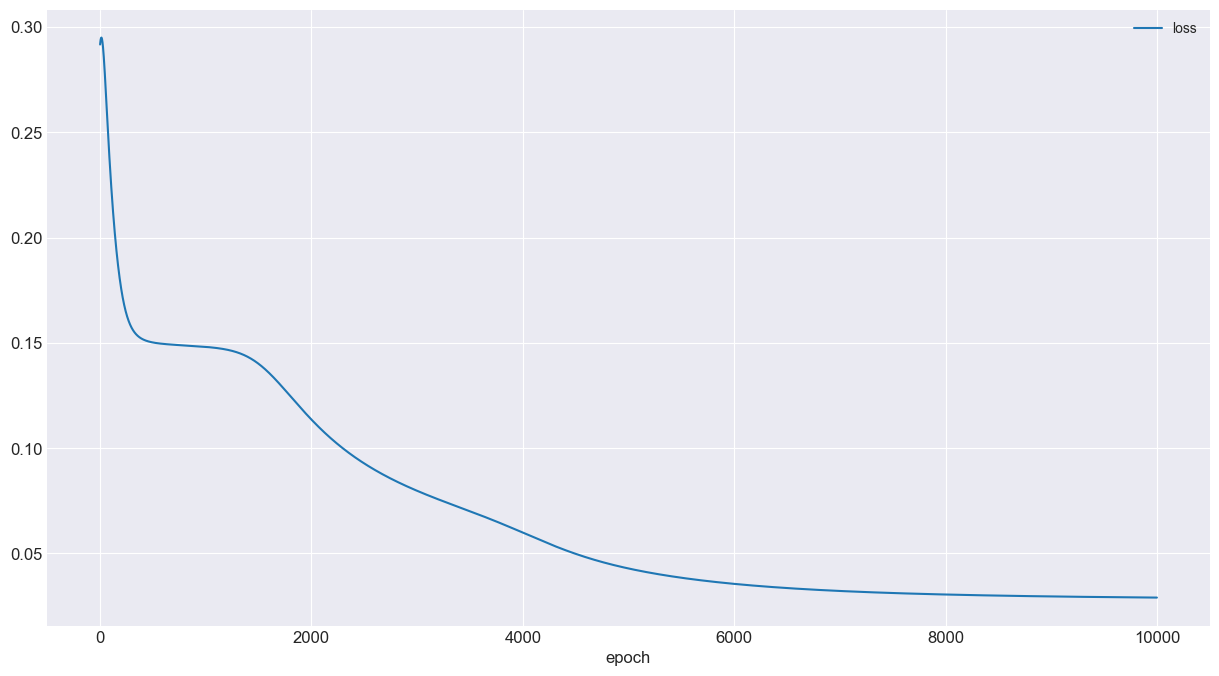

In [22]:
pd.DataFrame(loss_hist).plot(x = 'epoch')

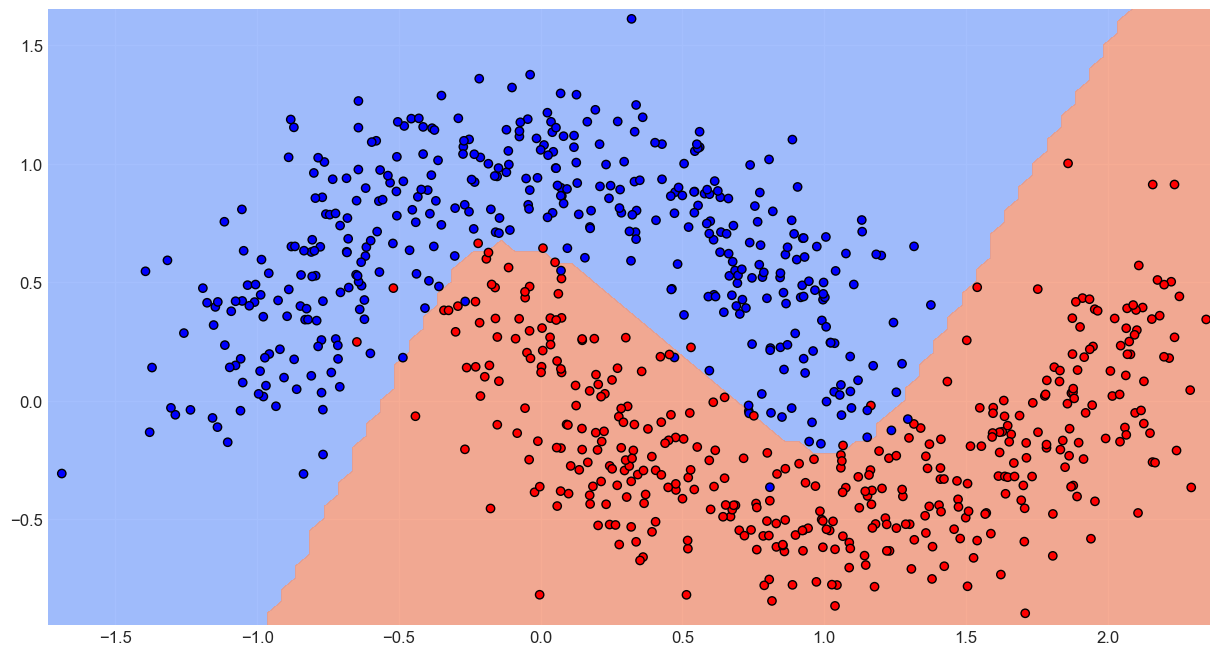

In [23]:
fig,ax = plt.subplots() ### instatiation of plt object
dm = 0.05 ## spacing of grid
x_min, x_max = X_train[:,0].min()-dm, X_train[:,0].max()+dm
y_min, y_max = X_train[:,1].min()-dm, X_train[:,1].max()+dm

xx,yy = np.meshgrid(np.arange(x_min, x_max,dm), np.arange(y_min, y_max,dm))  #### generate mesh

XX = np.c_[xx.ravel(),yy.ravel()] ### prepare feature data

y_pred = predict(model, XX)
Z = np.array(y_pred).reshape(xx.shape)

ax.contourf(xx,yy,Z,cmap = CMAP, alpha = 0.8)
ax.scatter(X_train[:,0],X_train[:,1],c = y_train,edgecolors = 'k',cmap = plt.cm.bwr)

In [ ]:
### training accuracy , loss, cf

In [24]:
y_pred = predict(model, X_train)
print(accuracy_score(y_train,y_pred))
print(Cal_loss(model, X_train,y_train))
cm = confusion_matrix(y_train,y_pred)
cm

0.9825
0.029059820318590703


array([[394,   6],
       [  8, 392]], dtype=int64)

In [ ]:
### testing accuracy , loss, cf

In [25]:
y_pred = predict(model, X_test)
print(accuracy_score(y_test,y_pred))
print(Cal_loss(model, X_test,y_test))
cm = confusion_matrix(y_test,y_pred)
cm

0.965
0.09848136858279492


array([[98,  2],
       [ 5, 95]], dtype=int64)

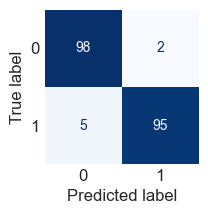

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[0,1])

fig,ax = plt.subplots(figsize=(2,2))
disp.plot(ax = ax,cmap='Blues',colorbar = False)
ax.grid(False)
plt.show()